# 데이터 로딩

In [90]:
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
    filename="../../data/nlp/ratings_train.txt",
)
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
    filename="../../data/nlp/ratings_test.txt",
)

('../../data/nlp/ratings_test.txt', <http.client.HTTPMessage at 0x3106517d0>)

In [91]:
import pandas as pd

df_train = pd.read_table("../../data/nlp/ratings_train.txt")
df_test = pd.read_table("../../data/nlp/ratings_test.txt")

# 텍스트 전처리

## Data Cleaning

In [92]:
import numpy as np


def preprocessing_naver_review(df):
    df.drop_duplicates(
        subset=["document"], inplace=True
    )  # document 열에서 중복인 내용이 있다면 중복 제거
    df["document"] = df["document"].str.replace(
        "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", ""
    )  # 정규 표현식 수행
    df["document"] = df["document"].str.replace("^ +", "")  # 공백은 empty 값으로 변경
    df["document"].replace("", np.nan, inplace=True)  # 공백은 Null 값으로 변경
    df = df.dropna(how="any")  # Null 값 제거

    return df


df_train = preprocessing_naver_review(df_train)
df_test = preprocessing_naver_review(df_test)

/var/folders/h0/f86w2r851zn7yj1w80yw932h0000gn/T/ipykernel_2553/2103672812.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["document"].replace("", np.nan, inplace=True)  # 공백은 Null 값으로 변경


In [93]:
df_train.isnull().sum(), df_test.isnull().sum()

(id          0
 document    0
 label       0
 dtype: int64,
 id          0
 document    0
 label       0
 dtype: int64)

## 형태소 분리

In [94]:
stopwords = [
    "의",
    "가",
    "이",
    "은",
    "들",
    "는",
    "좀",
    "잘",
    "걍",
    "과",
    "도",
    "를",
    "으로",
    "자",
    "에",
    "와",
    "한",
    "하다",
]

In [95]:
from konlpy.tag import Mecab

# 명시적으로 딕셔너리 경로를 지정합니다.
mecab = Mecab(dicpath="/opt/homebrew/lib/mecab/dic/mecab-ko-dic")

# 테스트 문장
sentence = "테스트 문장입니다."
print(mecab.morphs(sentence))

['테스트', '문장', '입니다', '.']


In [96]:
from tqdm import tqdm

X_train = []
for sentence in tqdm(df_train["document"]):
    tokenized_sentence = mecab.morphs(sentence)  # 토큰화
    stopwords_removed_sentence = [
        word for word in tokenized_sentence if not word in stopwords
    ]  # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 146182/146182 [00:05<00:00, 26545.28it/s]


In [97]:
X_test = []
for sentence in tqdm(df_test["document"]):
    tokenized_sentence = mecab.morphs(sentence)  # 토큰화
    stopwords_removed_sentence = [
        word for word in tokenized_sentence if not word in stopwords
    ]  # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 49157/49157 [00:01<00:00, 25428.38it/s]


## 각 단어의 빈도수 및 희귀 단어 확인

In [98]:
from collections import Counter

word_list = []

# 우리가 가진 학습 데이터의 모든 단어들을 하나의 리스트인 word_list에 저장
for sent in X_train:
    for word in sent:
        word_list.append(word)

# word_list 100개만 출력
print(word_list[:100])

word_counts = Counter(word_list)
print("총 단어수 :", len(word_counts))

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리', '흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나', '너무', '재', '밓었다그래서보는것을추천한다', '교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정', '사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다', '막', '걸음마', '뗀', '3', '세', '부터', '초등', '학교', '1', '학년', '생', '인', '8', '살', '용', '영화', '.', 'ㅋㅋㅋ', '.', '..', '별반', '개', '아까움', '.', '원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.']
총 단어수 : 54026


In [99]:
print("훈련 데이터에서의 단어 영화의 등장 횟수 :", word_counts["영화"])
print("훈련 데이터에서의 단어 송강호의 등장 횟수 :", word_counts["송강호"])
print("훈련 데이터에서의 단어 열외의 등장 횟수 :", word_counts["열외"])

훈련 데이터에서의 단어 영화의 등장 횟수 : 57345
훈련 데이터에서의 단어 송강호의 등장 횟수 : 74
훈련 데이터에서의 단어 열외의 등장 횟수 : 1


In [100]:
# 등장 빈도 순으로 정렬. 등장 빈도가 높은 순서가 앞으로 오도록 정렬
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print("등장 빈도수 상위 10개 단어")
print(vocab[:10])

등장 빈도수 상위 10개 단어
['.', '영화', '다', '고', '하', '을', '보', '..', '게', ',']


In [101]:
print(vocab)

['.', '영화', '다', '고', '하', '을', '보', '..', '게', ',', '!', '지', '있', '없', '?', '좋', '나', '었', '만', '는데', '너무', '봤', '적', '안', '로', '정말', '음', '것', '아', '네요', '어', '재밌', '같', '점', '지만', '진짜', '했', '기', '에서', '네', '않', '거', '았', '수', '되', '면', 'ㅋㅋ', '말', '인', '연기', '주', '내', '최고', '~', '평점', '이런', '던', '어요', '할', '왜', '겠', '해', '1', '스토리', '습니다', 'ㅋㅋㅋ', '...', '드라마', '아니', '생각', '더', '그', '싶', '사람', '듯', '때', '감동', '함', '배우', '본', '까지', '뭐', '보다', '알', '만들', '내용', '볼', '감독', '라', '그냥', '재미', '시간', '지루', '중', '재미있', '년', '10', '였', '잼', '사랑', '못', '냐', '재미없', '쓰레기', '서', '야', '2', '라고', '니', '면서', '번', '다시', '나오', '작품', '이거', '하나', '줄', '해서', '개', '정도', '남', '마지막', '끝', '액션', '이건', '임', '건', 'ㅋ', '3', '기대', '입니다', '라는', '분', '완전', '다는', '참', '많', '처음', '장면', '대', '아깝', '다가', '으면', '지금', '모르', '이렇게', "'", '편', '일', '성', '돈', '이게', '느낌', '시', '이야기', '최악', '된', '봐도', '님', '어서', '애', '전', '넘', 'ㅠㅠ', '다고', '인데', '그리고', '명작', '여자', '이해', '^^', '난', '역시', '또', '걸', '한국', '이상', '부터', '는지', '많이', '

In [102]:
print(len(vocab))

54026


In [103]:
threshold = 3
total_cnt = len(word_counts)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수: %s" % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 54026
등장 빈도가 2번 이하인 희귀 단어의 수: 31369
단어 집합에서 희귀 단어의 비율: 58.06278458519972
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6619230028461982


등장 빈도가 3( threshold ) 미만인 단어이 전체 단어에서 58정도 차지하고 있습니다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.76% 밖에 되지 않습니다.

별로 중요하지 않다고 생각됩니다.

In [104]:
total_cnt - rare_cnt

22657

In [105]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print("단어 집합의 크기 :", len(vocab))

단어 집합의 크기 : 22657


In [106]:
word_to_index = {}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = 1

In [107]:
for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

In [108]:
vocab_size = len(word_to_index)
print("패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :", vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 22659


## 정수인코딩 수행하기

In [109]:
def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index["<UNK>"])
        encoded_X_data.append(index_sequences)
    return encoded_X_data

In [110]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [111]:
print("인코딩 전 :", X_train[0])
print("인코딩 후 :", encoded_X_train[0])

인코딩 전 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
인코딩 후 : [30, 72, 937, 2, 2, 37, 227, 18, 31, 745]


In [112]:
print("인코딩 전 :", X_train[25])
print("인코딩 후 :", encoded_X_train[25])

인코딩 전 : ['다', '짤랐', '을', '꺼', '야', '.', '그래서', '납득', '할', '수', '없', '었', '던', '거', '야', '.', '.', '그럴', '꺼', '야', '.', '.', '꼭', '그랬', '던', '걸', '꺼', '야', '.', '.']
인코딩 후 : [4, 1, 7, 555, 107, 2, 597, 3058, 60, 45, 15, 19, 58, 43, 107, 2, 2, 1645, 555, 107, 2, 2, 204, 1010, 58, 176, 555, 107, 2, 2]


In [113]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [114]:
print(index_to_word)

{0: '<PAD>', 1: '<UNK>', 2: '.', 3: '영화', 4: '다', 5: '고', 6: '하', 7: '을', 8: '보', 9: '..', 10: '게', 11: ',', 12: '!', 13: '지', 14: '있', 15: '없', 16: '?', 17: '좋', 18: '나', 19: '었', 20: '만', 21: '는데', 22: '너무', 23: '봤', 24: '적', 25: '안', 26: '로', 27: '정말', 28: '음', 29: '것', 30: '아', 31: '네요', 32: '어', 33: '재밌', 34: '같', 35: '점', 36: '지만', 37: '진짜', 38: '했', 39: '기', 40: '에서', 41: '네', 42: '않', 43: '거', 44: '았', 45: '수', 46: '되', 47: '면', 48: 'ㅋㅋ', 49: '말', 50: '인', 51: '연기', 52: '주', 53: '내', 54: '최고', 55: '~', 56: '평점', 57: '이런', 58: '던', 59: '어요', 60: '할', 61: '왜', 62: '겠', 63: '해', 64: '1', 65: '스토리', 66: '습니다', 67: 'ㅋㅋㅋ', 68: '...', 69: '드라마', 70: '아니', 71: '생각', 72: '더', 73: '그', 74: '싶', 75: '사람', 76: '듯', 77: '때', 78: '감동', 79: '함', 80: '배우', 81: '본', 82: '까지', 83: '뭐', 84: '보다', 85: '알', 86: '만들', 87: '내용', 88: '볼', 89: '감독', 90: '라', 91: '그냥', 92: '재미', 93: '시간', 94: '지루', 95: '중', 96: '재미있', 97: '년', 98: '10', 99: '였', 100: '잼', 101: '사랑', 102: '못', 103: '냐', 104: '재미없', 105: 

In [115]:
idx = 25
decoded_sample = [index_to_word[word] for word in encoded_X_train[idx]]
print("기존의 첫번째 샘플 :", X_train[idx])
print("복원된 첫번째 샘플 :", decoded_sample)

기존의 첫번째 샘플 : ['다', '짤랐', '을', '꺼', '야', '.', '그래서', '납득', '할', '수', '없', '었', '던', '거', '야', '.', '.', '그럴', '꺼', '야', '.', '.', '꼭', '그랬', '던', '걸', '꺼', '야', '.', '.']
복원된 첫번째 샘플 : ['다', '<UNK>', '을', '꺼', '야', '.', '그래서', '납득', '할', '수', '없', '었', '던', '거', '야', '.', '.', '그럴', '꺼', '야', '.', '.', '꼭', '그랬', '던', '걸', '꺼', '야', '.', '.']


## 길이에 따른 padding 조절

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.983157981146789


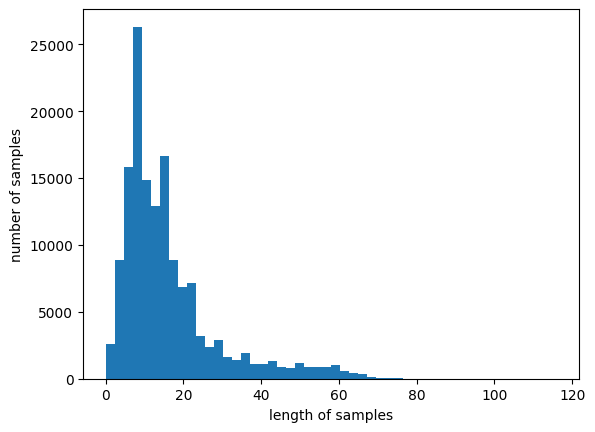

In [116]:
import matplotlib.pyplot as plt

print("리뷰의 최대 길이 :", max(len(review) for review in encoded_X_train))
print("리뷰의 평균 길이 :", sum(map(len, encoded_X_train)) / len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [117]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if len(sentence) <= max_len:
            count = count + 1
    print(
        "전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"
        % (max_len, (count / len(nested_list)) * 100)
    )

In [118]:
max_len = 80
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.9911069762351


In [119]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, : len(sentence)] = np.array(sentence)[:max_len]
    return features

In [120]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

In [121]:
from sklearn.model_selection import train_test_split

padded_X_train, padded_X_valid, y_train, y_valid = train_test_split(
    padded_X_train, df_train["label"], random_state=0, stratify=df_train["label"]
)

In [122]:
print("훈련 데이터의 크기 :", padded_X_train.shape)
print("검증 데이터의 크기 :", padded_X_valid.shape)
print("테스트 데이터의 크기 :", padded_X_test.shape)

훈련 데이터의 크기 : (109636, 80)
검증 데이터의 크기 : (36546, 80)
테스트 데이터의 크기 : (49157, 80)


In [123]:
y_test = df_test["label"]

In [124]:
padded_X_train[:5]

array([[  242,   999,  3237,    55,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 4785,    51,  2935,    12,    80,   198,    98,    35,  1758,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            

# 모델링

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F

USE_CUDA = torch.backends.mps.is_available()
device = torch.device("mps" if USE_CUDA else "cpu")
print("cpu와 mps 중 다음 기기로 학습함:", device)

cpu와 mps 중 다음 기기로 학습함: mps


In [126]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=32
)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, shuffle=True, batch_size=1
)

## 단방향 RNN

In [127]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNNClassifier, self).__init__()

        # embedding layer : 각 단어를 벡터화하는 층
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True
        )

        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)

    def forward(self, x):
        # x : (batch_size, t)
        projection = self.embedding(x)  # (batch_size, t, embedding_dim)

        # lstm_out : (batch_size, t, hidden_dim)
        # hidden : (1, batch_size, hidden_dim)
        lstm_out, (hidden, C) = self.lstm(projection)

        last_hidden = hidden.squeeze(0)

        out = self.fc(last_hidden)  # (batch_size, output_dim)

        return out

## 양방향 RNN

In [128]:
class BidirectionalRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BidirectionalRNNClassifier, self).__init__()

        # embedding layer : 각 단어를 벡터화하는 층
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True,
        )

        # 순방향 벡터와 역방향 벡터를 concat 해서 분류 작업 수행
        self.fc = nn.Linear(in_features=hidden_dim * 2, out_features=output_dim)

    def forward(self, x):
        projection = self.embedding(x)

        # hidden : (2, batch_size, hidden_dim)
        lstm_out, (hidden, C) = self.lstm(projection)

        # 순방향 context vector
        hidden_fw = hidden[0, :, :]  # (batch_size, hidden_dim)

        # 역방향 context vector
        hidden_bw = hidden[1, :, :]  # (batch_size, hidden_dim)

        # 두 방향의 hidden state 연결 (concat)
        final_hidden_state = torch.cat(
            (hidden_fw, hidden_bw), dim=1
        )  # (batch_size, hidden_dim * 2)

        out = self.fc(final_hidden_state)

        return out

## 단방향 다층 RNN

In [129]:
class UniRNNClassifier(nn.Module):
    # num_layers 추가. 여기서는 2층을 기본으로 설정함.
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(UniRNNClassifier, self).__init__()

        # embedding layer : 각 단어를 벡터화하는 층
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers=num_layers,
        )

        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)

    def forward(self, x):
        projection = self.embedding(x)

        # hidden : (num_layers, batch_size, hidden_dim)
        lstm_out, (hidden, C) = self.lstm(projection)

        # 가장 마지막 층의 context vector
        last_hidden = hidden[-1, :, :]

        out = self.fc(last_hidden)

        return out

## 양방향 다층 RNN

In [130]:
class BidirectionalUniRNNClassifier(nn.Module):
    # num_layers 추가. 여기서는 2층을 기본으로 설정함.
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(BidirectionalUniRNNClassifier, self).__init__()

        # embedding layer : 각 단어를 벡터화하는 층
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True,
            num_layers=num_layers,
        )

        self.fc = nn.Linear(in_features=hidden_dim * 2, out_features=output_dim)

    def forward(self, x):
        projection = self.embedding(x)
        lstm_out, (hidden, C) = self.lstm(projection)

        # hidden : (num_layers * 2, batch_size, hidden_size)
        hidden_fw = hidden[-2, :, :]  # 순방향의 마지막 층 hidden state
        hidden_bw = hidden[-1, :, :]  # 역방향의 마지막 층 hidden state

        final_hidden_state = torch.cat((hidden_fw, hidden_bw), dim=1)

        out = self.fc(final_hidden_state)

        return out

In [131]:
embedding_dim = 100  # 임베딩 벡터의 차원
hidden_dim = 128  # RNN의 은닉층의 크기. 은닉 상태 벡터의 차원
output_dim = 2  # 분류하고자하는 카테고리 개수
learning_rate = 0.01  # 학습률
num_epochs = 5  # 학습 횟수

In [132]:
# vocab_size = 38711
model = BidirectionalUniRNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

BidirectionalUniRNNClassifier(
  (embedding): Embedding(22659, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [134]:
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [135]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [136]:
# Training loop
best_val_loss = float("inf")

# Training loop
# epoch = 전체 데이터에 대한 학습 횟수.
# 전체 데이터가 5만개면 5만개를 한 번 다 훑는 것.
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()

    # train_dataloader 배치 크기 32
    # 데이터가 32개씩 꺼내와진다.
    for batch_X, batch_y in train_dataloader:

        # batch_X.shape == (batch_size, max_len)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        logits = model(batch_X)
        # print(logits.shape, batch_y.shape)
        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()  # 미분값 0으로 초기화
        loss.backward()  # 미분
        optimizer.step()  # 미분값을 바탕으로 모든 파라미터 업데이트

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(
            f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다."
        )
        best_val_loss = val_loss
        torch.save(
            model.state_dict(), "../../data/nlp/saved_models/best_model_checkpoint.pth"
        )

KeyboardInterrupt: 

# Inference

In [71]:
index_to_tag = {0: "부정", 1: "긍정"}


def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()
    tokenized_sentence = mecab.morphs(text)  # 토큰화
    stopwords_removed_sentence = [
        word for word in tokenized_sentence if not word in stopwords
    ]
    # Tokenize the input text

    token_indices = texts_to_sequences([stopwords_removed_sentence], word_to_index)
    padded_tensor = pad_sequences(token_indices, max_len)
    # Convert tokens to tensor
    input_tensor = torch.tensor(padded_tensor, dtype=torch.long).to(
        device
    )  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [72]:
predict("진짜 ㄹㅇ 개꿀잼", model, word_to_index, index_to_tag)

AttributeError: 'BidirectionalUniRNNClassifier' object has no attribute '_modules'